In [312]:
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [313]:
# size of around 400 images per class would be ideal

In [314]:
master_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/trashnet/dataset-resized',
    labels='inferred',
    image_size=(512, 256),
    batch_size=32,
    shuffle=True
)

Found 2527 files belonging to 6 classes.


In [315]:
class_names = master_dataset.class_names

In [316]:
def load_class_dataset(master_dataset, class_index, augment=False, num_samples=None):
    dataset = (master_dataset.unbatch()).filter(lambda x, y: tf.equal(y, class_index))

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"), # apply augmentation only if we have to make more images
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1)
        ])
        dataset = dataset.map(lambda x, y: (aug(x, training=True), y))

    if num_samples is not None:
        dataset = dataset.shuffle(buffer_size=num_samples, seed=123).repeat().take(num_samples)
    return dataset.batch(32)

In [317]:
batched_dataset = []
counts = [403, 501, 482, 594, 410, 137]
target_size = 400

for i, count in enumerate(counts):
    # need to cut out some of the images
    batched_dataset.append(load_class_dataset(master_dataset, i, count < target_size, target_size))

balanced_dataset = batched_dataset[0]
for dataset in batched_dataset[1:]:
    balanced_dataset = balanced_dataset.concatenate(dataset)

In [318]:
total_samples = target_size * len(class_names)
shuffled = balanced_dataset.unbatch().shuffle(total_samples, seed=123)

In [319]:
train_dataset = (
    shuffled.take(int(0.7 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    shuffled.skip(int(0.7 * total_samples)).take(int(0.2 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    shuffled.skip(int(0.9 * total_samples)).take(int(0.1 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

In [320]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #tf.keras.layers.RandomFlip('horizontal', input_shape=(512, 256, 3)),
    #tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.RandomZoom(0.2),
    #tf.keras.layers.RandomBrightness(0.2),
    #tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255, input_shape=(512, 256, 3)), # rescale the layer to fit within the 0-1 threshold
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.15),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [321]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [322]:
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)        │ (None, 512, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 510, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 255, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 253, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 126, 62, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 124, 60, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 119040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │    30,474,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,504,678 (116.37 MB)

 Trainable params: 30,504,678 (116.37 MB)

 Non-trainable params: 0 (0.00 B)

In [323]:
checkpoint_dir = '../models/'

In [324]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [325]:
fitted_model = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=4,
    callbacks=[checkpoint_cb]
)

Epoch 1/4
     53/Unknown 33s 441ms/step - accuracy: 0.2377 - loss: 4.4911
Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to ../models/epoch_01.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 656ms/step - accuracy: 0.2393 - loss: 4.4542 - val_accuracy: 0.5167 - val_loss: 1.3289
Epoch 2/4
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4675 - loss: 1.3676
Epoch 2: val_accuracy improved from 0.51667 to 0.56875, saving model to ../models/epoch_02.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.4680 - loss: 1.3664 - val_accuracy: 0.5688 - val_loss: 1.1616
Epoch 3/4
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5919 - loss: 1.0696
Epoch 3: val_accuracy improved from 0.56875 to 0.70417, saving model to ../models/epoch_03.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.5922 - loss: 1.0687 - val_accuracy: 0.7042 - val_loss: 0.9334
Epoch 4/4
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7312 - loss: 0.7918
Epoch 4: val_

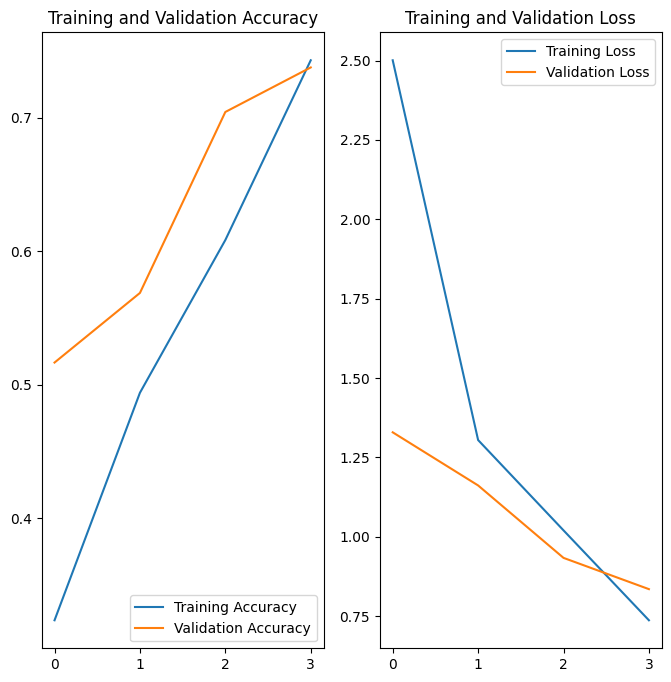

In [326]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [327]:
img = Image.open('../data/test/cardboard_test.jpeg').resize((512, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
This image most likely belongs to cardboard with a 35.21 percent confidence.
[0.3520854  0.12957416 0.1295733  0.12957327 0.12958741 0.12960646]


In [328]:
eval_result = model.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.7307 - loss: 0.8546
[test loss, test accuracy]: [0.844603955745697, 0.7291666865348816]


In [329]:
model.save('../models/model.keras')

In [330]:
# next step would be to hyperparameter tune and see if i can find better parameters